In [5]:
import os
import torchvision.models as models 
import torch.nn as nn
import torch
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision
from glob import glob
from torchinfo import summary
import numpy as np
import torch.functional as F
import torchvision.transforms as T
from tqdm.auto import tqdm
import torchmetrics
import math
import cv2
device0 = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
Type_class='Type_All'
batch_size=256

In [2]:
#dataload
def resized(data,N):
    M=data.size
    res=np.empty(N,data.dtype)
    carry=0
    m=0
    for n in range(N):
        sum = carry
        while m*N - n*M < M :
            sum += data[m]
            m += 1
        carry = (m-(n+1)*M/N)*data[m-1]
        sum -= carry
        res[n] = sum*N/M
    return res

class CustomDataset(Dataset):
    def __init__(self, data,label ,transform=None, target_transform=None):
        self.PPG_data=data
        self.PPG_label=label
    def __len__(self):
        return len(self.PPG_data)

    def __getitem__(self, idx):
        signal_tensor=self.PPG_data[idx]
        AF_signal_label=self.PPG_label[idx]
        return signal_tensor,AF_signal_label
    
train_csv_path ='../../data/AF/Waveform_30/train/'
test_csv_path ='../../data/AF/Waveform_30/test/'

train_data_list=glob(train_csv_path+Type_class+'/**/*.csv')
test_data_list=glob(test_csv_path+Type_class+'/**/*.csv')
train_data=torch.empty(len(train_data_list),1,750)
train_label=torch.empty(len(train_data_list),1)
test_data=torch.empty(len(test_data_list),1,750)
test_label=torch.empty(len(test_data_list),1)
for i in tqdm(range(len(train_data_list))):
    signal_csv=pd.read_csv(train_data_list[i])['PPG'].to_numpy()
    train_data_list[i].find('positive')
    AF_signal_label=0
    if train_data_list[i].find('positive')!=-1:
        AF_signal_label=1
    else:
        AF_signal_label=0
    train_data[i]=torch.tensor(resized(signal_csv,750))
    train_label[i]=torch.tensor([AF_signal_label])
    
for i in tqdm(range(len(test_data_list))):
    signal_csv=pd.read_csv(test_data_list[i])['PPG'].to_numpy()
    test_data_list[i].find('positive')
    AF_signal_label=0
    if test_data_list[i].find('positive')!=-1:
        AF_signal_label=1
    else:
        AF_signal_label=0
    test_data[i]=torch.tensor(resized(signal_csv,750))
    test_label[i]=torch.tensor([AF_signal_label])

train_dataset=CustomDataset(train_data,train_label)
test_dataset=CustomDataset(test_data ,test_label)
dataset_size = len(test_dataset)
test_size = int(dataset_size * 0.5)
validation_size = dataset_size-test_size
validation_dataset, test_dataset = random_split(test_dataset, [validation_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

  0%|          | 0/22184 [00:00<?, ?it/s]

  0%|          | 0/5460 [00:00<?, ?it/s]

In [14]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]   
    
class TransAm(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)
        output = self.decoder(output)
        output=output.squeeze(1)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


    
accuracy = torchmetrics.Accuracy(task="binary", num_classes=1).to(device0)
model = TransAm(feature_size=750, num_layers=2, dropout=0.1).to(device0)
criterion = nn.BCEWithLogitsLoss().to(device0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
summary(model,[(batch_size,1,750)])

Layer (type:depth-idx)                        Output Shape              Param #
TransAm                                       [256, 1]                  5,330,798
├─PositionalEncoding: 1-1                     [256, 1, 750]             --
├─TransformerEncoder: 1-2                     [256, 1, 750]             --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [256, 1, 750]             5,330,798
│    │    └─TransformerEncoderLayer: 3-2      [256, 1, 750]             5,330,798
├─Linear: 1-3                                 [256, 1, 1]               751
Total params: 15,993,145
Trainable params: 15,993,145
Non-trainable params: 0
Total mult-adds (G): 1.58
Input size (MB): 0.77
Forward/backward pass size (MB): 17.61
Params size (MB): 24.63
Estimated Total Size (MB): 43.00

epoch: 1/1000 train_loss : 0.8423 train_accuracy: 0.5052 val_loss : 0.6892  val_accuracy: 0.5270
epoch: 2/1000 train_loss : 0.6977 train_accuracy: 0.5344 val_loss : 0.6900  val_accuracy: 0.5293


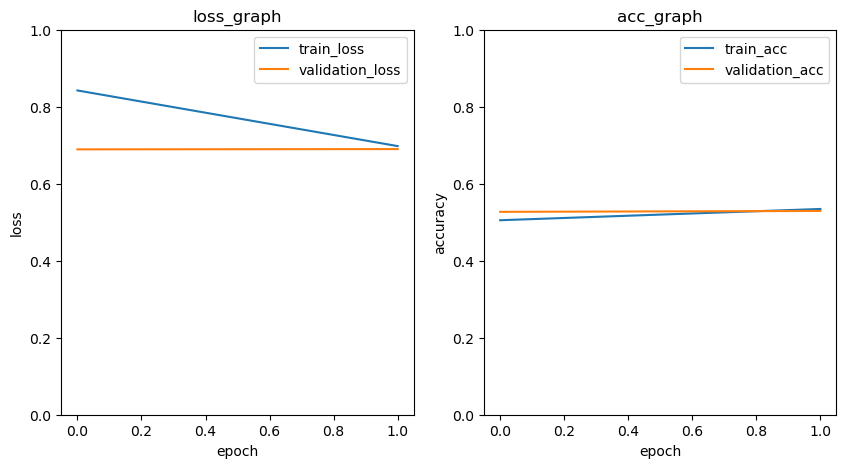

epoch: 3/1000 train_loss : 0.6919 train_accuracy: 0.5460 val_loss : 0.7038  val_accuracy: 0.5055
epoch: 4/1000 train_loss : 0.6987 train_accuracy: 0.5380 val_loss : 0.7542  val_accuracy: 0.4629
epoch: 5/1000 train_loss : 0.6887 train_accuracy: 0.5525 val_loss : 0.7032  val_accuracy: 0.5090
epoch: 6/1000 train_loss : 0.6813 train_accuracy: 0.5578 val_loss : 0.7095  val_accuracy: 0.5047
epoch: 7/1000 train_loss : 0.6778 train_accuracy: 0.5694 val_loss : 0.6892  val_accuracy: 0.5188
epoch: 8/1000 train_loss : 0.6686 train_accuracy: 0.5813 val_loss : 0.6943  val_accuracy: 0.5324
epoch: 9/1000 train_loss : 0.6618 train_accuracy: 0.5928 val_loss : 0.7240  val_accuracy: 0.5031
epoch: 10/1000 train_loss : 0.6561 train_accuracy: 0.5995 val_loss : 0.7251  val_accuracy: 0.5156
epoch: 11/1000 train_loss : 0.6433 train_accuracy: 0.6194 val_loss : 0.7219  val_accuracy: 0.5301
epoch: 12/1000 train_loss : 0.6273 train_accuracy: 0.6394 val_loss : 0.7114  val_accuracy: 0.5543
epoch: 13/1000 train_loss :

KeyboardInterrupt: 

In [15]:
MIN_loss=5000
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
for epoch in range(1000):
    
    train_count=0
    running_loss = 0.0
    acc_loss=0
    for x, y in train_dataloader:
        model.train()
        y = y.to(device0).float()
        train_count+=1
        x=x.to(device0).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device0)
        cost = criterion(predict, y) # cost 구함
        acc=accuracy(predict, y)
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
    
    train_loss_list.append((running_loss/train_count))
    train_acc_list.append((acc_loss/train_count).cpu().detach().numpy())
#validation
    model.eval()
    val_count=0
    val_running_loss=0.0
    val_acc_loss=0
    with torch.no_grad():
        for x, y in validation_dataloader:
            y = y.to(device0).float()
            val_count+=1
            x=x.to(device0).float()
            
            predict = model(x).to(device0)
            acc=accuracy(predict, y)
            cost = criterion(predict, y)
            val_running_loss+=cost.item()
            val_acc_loss+=acc
        print(f"\repoch: {epoch+1}/{1000} train_loss : {running_loss/train_count:.4f} train_accuracy: {acc_loss/train_count:.4f} val_loss : {val_running_loss/val_count:.4f}  val_accuracy: {val_acc_loss/val_count:.4f}")
        
        val_loss_list.append((val_running_loss/val_count))
        val_acc_list.append((val_acc_loss/val_count).cpu().detach().numpy())
    if epoch%100==1:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
        
    if MIN_loss>(val_running_loss/val_count):
        torch.save(model.state_dict(), '../../model/Waveform/'+Type_class+'TST_call_back.pt')
        MIN_loss=(val_running_loss/val_count)
torch.save(model.state_dict(), '../../model/Waveform/'+Type_class+'/TST.pt')